In [ ]:
!pip install metagpt

在MetaGPT中定义的一个agent运行示例如下：

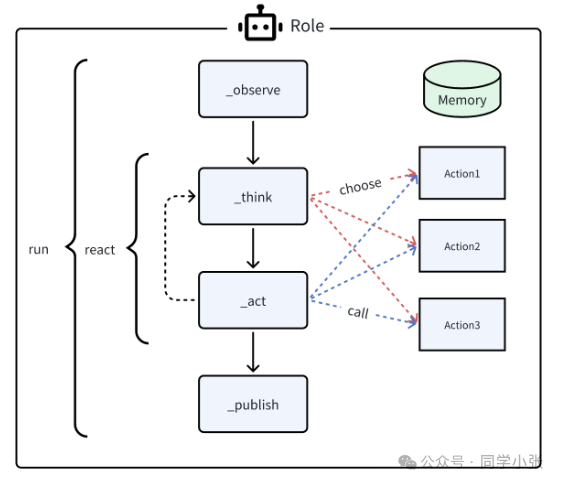

* 一个agent在启动后他会观察自己能获取到的信息，加入自己的记忆中

* 下一步进行思考，决定下一步的行动，也就是从Action1，Action2，Action3中选择执行的Action

* 决定行动后，紧接着就执行对应行动，得到这个环节的结果

以Task3 作业为例，来看下使用MetaGPT 实现Agent的思路。Task3任务如下：

| 经过上面的学习，我想你已经对 MetaGPT 的框架有了基本了解，现在我希望你能够自己编写这样一个 agent

* 这个 Agent 拥有三个动作 打印1 打印2 打印3（初始化时 init_action([print,print,print])）

* 重写有关方法（请不要使用act_by_order，我希望你能独立实现）使得 Agent 顺序执行上面三个动作

* 当上述三个动作执行完毕后，为 Agent 生成新的动作 打印4 打印5 打印6 并顺序执行，（之前我们初始化了三个 print 动作，执行完毕后，重新 init_action([…,…,…])，然后顺序执行这个新生成的动作列表)

# 实现思路
用最通俗的话来总结：

1. 要实现一个Agent，其实就是定义一个Role。该Role应该包含自己的Action。

2. 在Role的初始化中初始化Actions

3. Role重写_act函数或_react函数，Role run的时候会调用该函数

_react函数重写，一般是先思考_think下一步用哪个action，然后再_act

4. Action重写run函数，这里面决定了我们对传入的内容到底要做什么样的处理，例如调用大模型得到结果

# Task3 - 完整代码及注释


完整代码及细节注释

In [ ]:
# 加载 .env 到环境变量
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

from metagpt.actions import Action
from metagpt.logs import logger
import asyncio
from metagpt.roles import Role
from metagpt.schema import Message

## 1. 定义Action
class PrintAction(Action):
    def __init__(self, name: str = "", number: int = 0, *args, **kwargs):
        super().__init__(name, *args, **kwargs)
        self._number = number

    ## 1.1 run方法中定义具体的处理操作，这里只是打印一个数
    async def run(self):
        logger.info(self._number)
        return self._number


## 2. 定义Role
class Printer(Role):
    def __init__(
        self,
        name: str = "Printer",
        profile: str = "Printer",
    ):
        super().__init__(name, profile)

        ## 2.1 初始化中初始化该Role的Actions，这里首先初始化了3个Action，将会按顺序执行
        self._init_actions([PrintAction(number=1), PrintAction(number=2), PrintAction(number=3)])

    async def _think(self) -> None:
        """Determine the next action to be taken by the role."""
        logger.info(self._rc.state)
        logger.info(self,)
        logger.info(f"{self._setting}: ready to {self._rc.todo}")
        if self._rc.todo is None:
            self._set_state(0) # 这里回到了第一个Action
            logger.debug("reset state to 0")
            return

        ## 这里决定下一个action是什么，_rc.state表示要执行的action的下标，_states记录了所有actions及其下标
        if self._rc.state + 1 < len(self._states):
            logger.debug(f"set state to {self._rc.state + 1}")
            self._set_state(self._rc.state + 1) # todo变为下一个action
        else:
            self._rc.todo = None

    async def _act(self):
        todo = self._rc.todo
        if type(todo) is PrintAction:
            ret = await todo.run()
            if 3 == ret: # 这里判断下是第几个action了，根据任务描述，第三个任务完成后动态添加4,5,6 action
                actions = [PrintAction(number=4), PrintAction(number=5), PrintAction(number=6)]
                self._init_actions(actions) # 动态添加4,5,6 action，这时候action4变成了第一个action
                self._rc.todo = None # _think中会设置为第一个Action，也就是action4

        return "Continue"

    ## 3. 重写_react函数
    async def _react(self):
        while True:
            logger.info("react")
            await self._think() ## 首先思考下一步执行哪个action
            if self._rc.todo is None:
                break
            result = await self._act() ## 执行action，这里的action是_think里决定

async def main():
    msg = "start" ## 给一个msg，必须给一个非空的msg，否则run不起来，待研究
    role = Printer()
    await role.run(msg) ## 开始运行agent，会调用role里的_react

asyncio.run(main())

先看执行结果：顺序打印1-6，然后结束

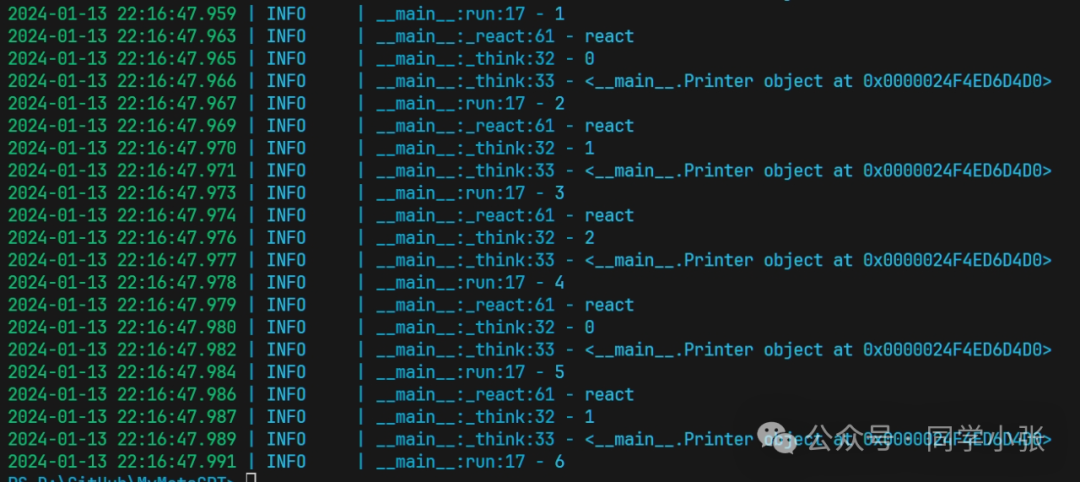